<a href="https://colab.research.google.com/github/PedroJuiz/DeepLearning/blob/main/Object_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Challenge S5: Reconocimiento de objetos con CIFAR-10

## Objetivos

El objetivo de este challenge es profundizar en nuestro conocimiento de las redes neuronales convolucionales en Keras.

Para ello, vamos a realizar las siguientes tareas:
- Cargar y comprender el dataset CIFAR10
- Crear y entrenar un modelo desde 0
- Cargar y ajustar un modelo preentrenado
- Obtener las curvas de entrenamiento de ambos modelos para comparar su aprendizaje.


## Tareas


### Configurando el entorno

Como siempre, comenzamos importando los módulos y librerías que vamos a necesitar, además, vamos a fijar una semilla para que las inicializaciones aleatorias sean igual aunque lo ejecutemos varias veces, y así los experimentos siempre salgan igual y poder encontrar fallos más fácilmente.

A continuación, podemos añadir todas las librerías que necesitemos:


In [ ]:
############## Si al ejecutar el Kernel se bloquea,
############## utiliza estas líneas para permitir la
############## duplicación de librerías
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
##############

# %tensorflow_version 2.x  # sólo es necesaria en colab
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow import keras

import numpy as np
np.random.seed(123)  # for reproducibility

import matplotlib.pyplot as plt


### Cargar y normalizar los datos de entrada: CIFAR-10

Como hemos visto en el worksheet, podemos cargar los datos de la base de datos CIFAR-10 y normalizarlos al rango [0,1] para prepararlos para nuestra red.

Recordad hacer una partición de datos de validación seleccionando 5.000 imágenes de entrenamiento.

A continuación, incluya el código necesario:

In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_valid = x_train[:5000]
y_valid = y_train[:5000]

x_train = x_train[5000:]
y_train = y_train[5000:]

n_classes = len(np.unique(y_train))

y_train = keras.utils.to_categorical(y_train, n_classes)
y_valid = keras.utils.to_categorical(y_valid, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_valid.shape)
print('y_val shape:', y_valid.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 10)
x_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


### Modelo 1: entrenado desde 0

#### Definición del modelo

Para resolver este problema vamos a comenzar con una estructura un poco más profunda que las vistas hasta ahora. Debemos completar la celda a continuación para declarar el siguiente modelo:

- Capa de entrada convolucional, 32 filtros de tamaño 3x3 con función de activación relu (recordar que en la capa de entrada hay que especificar el tamaño de entrada)
- Capa convolucional, 32 filtros de tamaño 3x3, con función de activación relu
- Capa dropout de probabilidad 25%
- Capa Max Pooling de tamaño 2x2
- Capa convolucional, 64 filtros de tamaño 3x3, con función de activación relu
- Capa dropout de probabilidad 25%
- Capa convolucional, 64 filtros de tamaño 3x3, con función de activación relu
- Capa dropout de probabilidad 25%
- Capa Max Pooling de tamaño 2x2
- Capa flatten
- Capa feed-forward (Dense en Keras) con 512 neuronas y función de activación relu
- Capa dropout de probabilidad 40%
- Capa de salida feed-forward (Dense en Keras) con función de activación softmax

Para resolver este paso sería interesante fijarse en la documentación de keras https://keras.io/layers/core/

Además, se puede comprobar el modelo creado con la función "summary": model.summary()

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (32,32,3)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.40))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                        

#### Compilando y entrenando el modelo

El siguiente paso que debemos hacer es compilar y entrenar el modelo.

En esta ocasión vamos a utilizar la función de coste 'categorical_crossentropy' y el optimizador adam. Además añadiremos, como habitualmente, la métrica 'accuracy' para visualizarla.

Recordad utilizar el conjunto de datos de validación que hemos separado del train al principio del challenge.

Para entrenar el modelo, definimos el número de épocas (ejemplo, 100) y el tamaño del batch (ejemplo, 128).

Si trabajamos con todo CIFAR-10 el entrenamiento va a ser muy lento, por lo que podemos diezmar los datos (usar 500 datos de train y 100 de test) y utilizar tan solo 10 épocas hasta estar 100% seguros de que todo está bien hecho. Una vez que la programación sea correcta ya podemos aumentar a todos los datos y correr la red. Una opción muy interesante es correr todo el entrenamiento en colab con GPU, lo que acelerará muchísimo el entrenamiento.

Conviene guardar la salida de la función fit ('history'), para analizar posteriormente su rendimiento.

Escribir el código necesario para hacer esto en la celda siguiente:

In [ ]:
x_train_prueba = x_train[:500]
y_train_prueba = y_train[:500]

x_test_prueba = x_test[:100]
y_test_prueba = y_test[:100]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=100,
          verbose=1, validation_data=[x_valid, y_valid])

score = model.evaluate(x_test, y_test, verbose=0)
print(score)

Epoch 1/100
352/352 [==============================] - 16s 14ms/step - loss: 1.6501 - accuracy: 0.3903 - val_loss: 1.4569 - val_accuracy: 0.4948
Epoch 2/100
352/352 [==============================] - 4s 12ms/step - loss: 1.2426 - accuracy: 0.5576 - val_loss: 1.2083 - val_accuracy: 0.6166
Epoch 3/100
352/352 [==============================] - 5s 14ms/step - loss: 1.0639 - accuracy: 0.6231 - val_loss: 1.0221 - val_accuracy: 0.6638
Epoch 4/100
352/352 [==============================] - 4s 12ms/step - loss: 0.9391 - accuracy: 0.6716 - val_loss: 0.9369 - val_accuracy: 0.6964
Epoch 5/100
352/352 [==============================] - 4s 12ms/step - loss: 0.8510 - accuracy: 0.7005 - val_loss: 0.8497 - val_accuracy: 0.7146
Epoch 6/100
352/352 [==============================] - 4s 11ms/step - loss: 0.7819 - accuracy: 0.7271 - val_loss: 0.8049 - val_accuracy: 0.7356
Epoch 7/100
352/352 [==============================] - 4s 12ms/step - loss: 0.7210 - accuracy: 0.7482 - val_loss: 0.7487 - val_accuracy

### Modelo 2 (preentrenado)

#### Definición del modelo

El modelo será el siguiente:

- Modelo preentrenado VGG16 (recordad no cargar la parte final, utilizar pesos de imagenet y congelar)
- Capa feed-forward de tamaño 512
- Capa dropout de probabilidad 40%
- Capa de salida


In [ ]:
from keras.layers.serialization import activation
base_model = tf.keras.applications.VGG16(input_shape = (32,32,3), include_top=False, weights = 'imagenet')
base_model.trainable = False
flatten = tf.keras.layers.Flatten()
classif = tf.keras.layers.Dense(512)
dropout = tf.keras.layers.Dropout(0.40)
output = tf.keras.layers.Dense(n_classes, activation = 'softmax')

model_2 = tf.keras.Sequential([
    base_model,
    flatten,
    classif,
    dropout,
    output
])

model_2.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_____________________________________

#### Compilando y entrenando el modelo

Repetir ahora los pasos de compilación y entrenamiento anteriores con el nuevo modelo.

NOTA: Guardar el historial del entrenamiento en una variable 'history2' para evaluar su rendimiento y compararlo con el anterior.

In [ ]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

history2 = model.fit(x_train, y_train, batch_size=128, epochs=100,
          verbose=1, validation_data=[x_test, y_test])

score = model.evaluate(x_test, y_test, verbose=0)
print(score)

Epoch 1/100
352/352 [==============================] - 5s 13ms/step - loss: 0.1404 - accuracy: 0.9525 - val_loss: 0.8541 - val_accuracy: 0.7834
Epoch 2/100
352/352 [==============================] - 5s 13ms/step - loss: 0.1345 - accuracy: 0.9532 - val_loss: 0.8363 - val_accuracy: 0.7829
Epoch 3/100
352/352 [==============================] - 4s 12ms/step - loss: 0.1383 - accuracy: 0.9531 - val_loss: 0.8481 - val_accuracy: 0.7812
Epoch 4/100
352/352 [==============================] - 4s 12ms/step - loss: 0.1434 - accuracy: 0.9507 - val_loss: 0.8173 - val_accuracy: 0.7823
Epoch 5/100
352/352 [==============================] - 5s 13ms/step - loss: 0.1341 - accuracy: 0.9537 - val_loss: 0.8474 - val_accuracy: 0.7833
Epoch 6/100
352/352 [==============================] - 4s 12ms/step - loss: 0.1426 - accuracy: 0.9509 - val_loss: 0.8676 - val_accuracy: 0.7769
Epoch 7/100
352/352 [==============================] - 4s 12ms/step - loss: 0.1437 - accuracy: 0.9507 - val_loss: 0.8771 - val_accuracy:


### Comparación de rendimientos

#### Rendimiento modelo 1 (entrenado desde 0)

Utilizando el material de la sesión anterior, a continuación, pinte las curvas de rendimiento (train y test) del modelo 1.

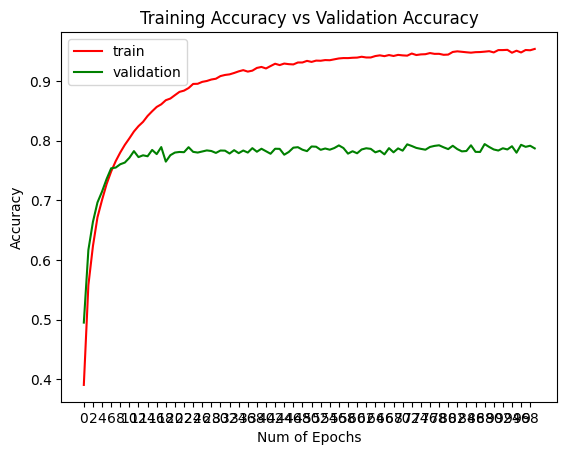

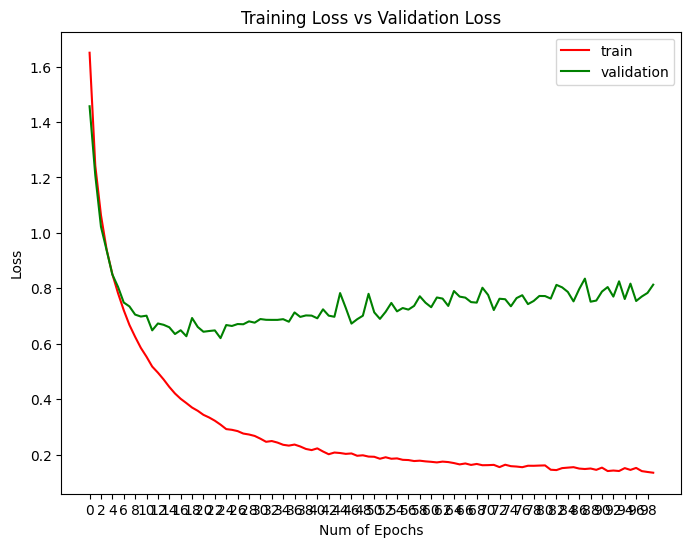

In [ ]:
def plotCurves(history,epochs):

    plt.figure(0)
    plt.plot(history.history['accuracy'],'r')
    plt.plot(history.history['val_accuracy'],'g')
    plt.xticks(np.arange(0, epochs, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train','validation'])


    plt.figure(1)
    plt.plot(history.history['loss'],'r')
    plt.plot(history.history['val_loss'],'g')
    plt.xticks(np.arange(0, epochs, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])


    plt.show()

plotCurves(history,100)

¿Te parecen buenas curvas de aprendizaje?

El efecto que se muestra, ¿tiene algún nombre? ¿A qué cosas suele deberse? En nuestro caso, ¿a qué se debe?

Las curvas de aprendizaje no son muy buenas debido a que el modelo sufre de overfitting (sobreentrenamiento). Esto puede deberse a que nuestro modelo es muy complejo o muy profundo para el problema que queremos resolver. Habría que probar a reducir la profundidad del modelo para quedarnos en un punto en el que no sobreentrene pero las métricas de validación no sean bajas.


#### Rendimiento modelo 2 (preentrenamiento)

Repita el análisis para el modelo 2.

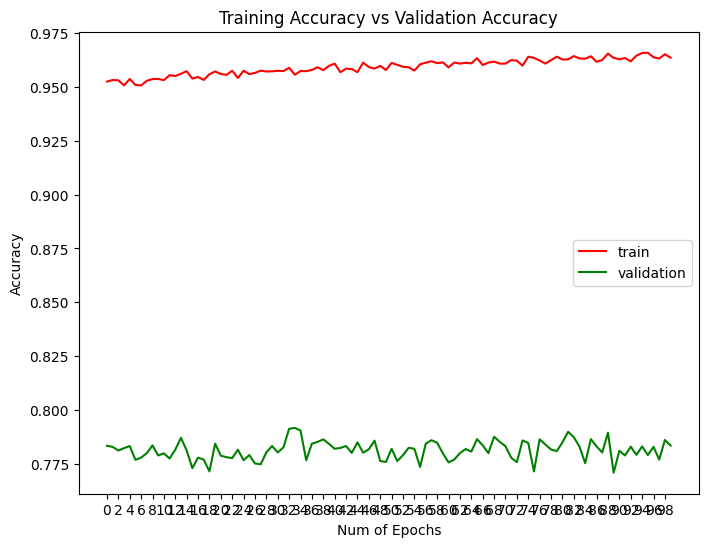

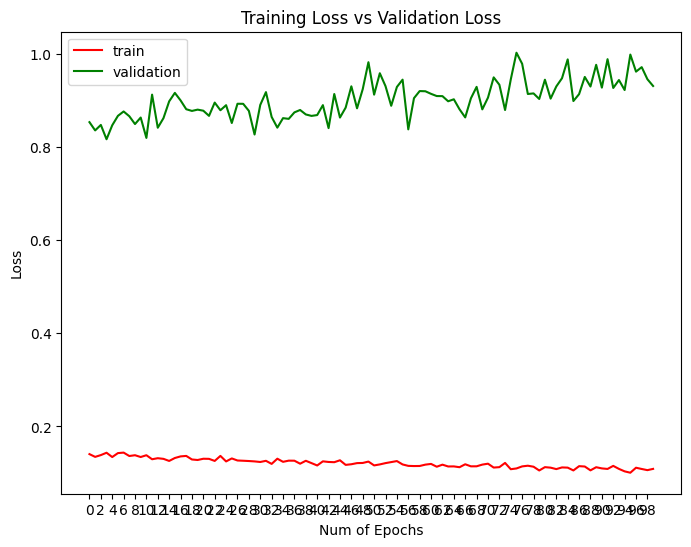

In [ ]:
plotCurves(history2, 100)

Analiza ahora las curvas para el segundo modelo. ¿Te parecen mejores las curvas ahora?

Con este modelo pasa un poco como con el anterior, es un modelo demasiado potente para la complejidad de nuestro problema, por lo tanto tiende a sobreentrenarse.